In [238]:
%matplotlib inline
import warnings

import pickle
import random
from time import time
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [239]:
data = pd.read_csv('/Users/patricia/Downloads/seasonal_gdp.csv')
data.describe(include = 'all')

,Date,GDP
count,118,118.000000
unique,118,NaN
top,2014年第四季度,NaN
freq,1,NaN
mean,NaN,92146.383051
std,NaN,82182.611122
min,NaN,5262.800000
25%,NaN,23128.475000
50%,NaN,56612.000000
75%,NaN,152120.025000


In [240]:
from functools import reduce 
def str2float(s):
    def dict(s):
        dict1 ={'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,'.':'.'}
        return dict1[s]  
    def fn(x,y):
        return x*10+y
    a =0
    for i in s :
        a +=1
        if i =='.':
            s = s[:a-1]+s[a:]
            break
    if a ==len(s):
        return reduce(fn,map(dict,s))
    else:
        return reduce(fn,map(dict,s))/(10**(len(s)-a+1))

def format_float(x):
    try:
        return float(x)
    except ValueError:
        x=x.replace(",","")
        return str2float(x)

for col in data.columns:
    if col !="Date":
        data[col]=data[col].apply(lambda x: format_float(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    118 non-null    object 
 1   GDP     118 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [241]:
df=data[["Date","GDP"]]
df.head()

,Date,GDP
0,2021年第二季度,282857.4
1,2021年第一季度,249310.1
2,2020年第四季度,296297.8
3,2020年第三季度,264976.3
4,2020年第二季度,248985.1


In [242]:
#df=np.array(df)
def dateformat(date):
    if date[6]=='一':
        return date[:4]+'-01'
    elif date[6]=='二':
        return date[:4]+'-02'
    elif date[6]=='三':
        return date[:4]+'-03'
    elif date[6]=='四':
        return date[:4]+'-04'
    else:
        pass
    
df["Date"]=df["Date"].apply(lambda x:dateformat(x))
df=df.sort_values("Date")
df.head()

,Date,GDP
117,1992-01,5262.8
116,1992-02,6484.3
115,1992-03,7192.6
114,1992-04,8254.8
113,1993-01,6834.6


In [243]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = px.line(df, x=df.Date, y=df.GDP)
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='GDP chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [244]:
import math
df['GDP'] = df['GDP'].apply(lambda x: math.log(x))

fig = px.line(df, x=df.Date, y=df.GDP)
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='GDP chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [245]:
from sklearn.preprocessing import MinMaxScaler
closedf = df.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
df.head()

(118, 1)


,Date,GDP
117,1992-01,8.568418
116,1992-02,8.777139
115,1992-03,8.880808
114,1992-04,9.018550
113,1993-01,8.829753


In [246]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (76, 1)
test_data:  (42, 1)


In [247]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (65, 10)
y_train:  (65,)
X_test:  (31, 10)
y_test (31,)


In [248]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (65, 10, 1)
X_test:  (31, 10, 1)


In [249]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
import warnings
warnings.filterwarnings(action='ignore', message='Setting attributes')

In [250]:
num_samples, time_steps, input_dim, output_dim = 500, 10, 2, 1

# Definition of the model.
model_keras = NBeatsKeras(backcast_length=time_steps, forecast_length=output_dim,
                          stack_types=(NBeatsKeras.TREND_BLOCK, NBeatsKeras.SEASONALITY_BLOCK),
                          nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
                          hidden_layer_units=64)
# Definition of the objective function and the optimizer.
model_keras.compile(loss='mae', optimizer='adam')

# Train the model.
print('Keras training...')
m=model_keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=256, batch_size=128)

# Save the model for later.
model_keras.save('n_beats_model')

# Predict on the testing set (forecast).
test_size = len(X_test)
predictions_keras_forecast = model_keras.predict(X_test)
np.testing.assert_equal(predictions_keras_forecast.shape, (test_size, model_keras.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_keras_backcast = model_keras.predict(X_test, return_backcast=True)
np.testing.assert_equal(predictions_keras_backcast.shape, (test_size, model_keras.backcast_length, output_dim))

# Load the model.
model_keras_2 = NBeatsKeras.load('n_beats_model')

np.testing.assert_almost_equal(predictions_keras_forecast, model_keras_2.predict(X_test))


Keras training...
Epoch 1/256
1/1 [==============================] - 1s 1s/step - loss: 0.3847 - val_loss: 0.9148
Epoch 2/256
1/1 [==============================] - 0s 22ms/step - loss: 0.3665 - val_loss: 2.2051
Epoch 3/256
1/1 [==============================] - 0s 23ms/step - loss: 1.4565 - val_loss: 0.7388
Epoch 4/256
1/1 [==============================] - 0s 27ms/step - loss: 0.5336 - val_loss: 1.0133
Epoch 5/256
1/1 [==============================] - 0s 23ms/step - loss: 0.5136 - val_loss: 1.3647
Epoch 6/256
1/1 [==============================] - 0s 21ms/step - loss: 0.7238 - val_loss: 1.2990
Epoch 7/256
1/1 [==============================] - 0s 23ms/step - loss: 0.6789 - val_loss: 1.1233
Epoch 8/256
1/1 [==============================] - 0s 24ms/step - loss: 0.5744 - val_loss: 1.0337
Epoch 9/256
1/1 [==============================] - 0s 21ms/step - loss: 0.5360 - val_loss: 1.1244
Epoch 10/256
1/1 [==============================] - 0s 21ms/step - loss: 0.5860 - val_loss: 0.9867
Epo

1/1 [==============================] - 0s 20ms/step - loss: 0.1175 - val_loss: 0.3248
Epoch 84/256
1/1 [==============================] - 0s 22ms/step - loss: 0.1573 - val_loss: 0.1771
Epoch 85/256
1/1 [==============================] - 0s 21ms/step - loss: 0.0798 - val_loss: 0.1127
Epoch 86/256
1/1 [==============================] - 0s 24ms/step - loss: 0.0688 - val_loss: 0.2177
Epoch 87/256
1/1 [==============================] - 0s 22ms/step - loss: 0.1202 - val_loss: 0.2078
Epoch 88/256
1/1 [==============================] - 0s 22ms/step - loss: 0.1140 - val_loss: 0.0945
Epoch 89/256
1/1 [==============================] - 0s 20ms/step - loss: 0.0570 - val_loss: 0.1562
Epoch 90/256
1/1 [==============================] - 0s 20ms/step - loss: 0.0713 - val_loss: 0.2237
Epoch 91/256
1/1 [==============================] - 0s 20ms/step - loss: 0.1069 - val_loss: 0.0980
Epoch 92/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0456 - val_loss: 0.1360
Epoch 93/256
1/1 [=====

1/1 [==============================] - 0s 20ms/step - loss: 0.0192 - val_loss: 0.0553
Epoch 166/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0304 - val_loss: 0.0263
Epoch 167/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0194 - val_loss: 0.0641
Epoch 168/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0254 - val_loss: 0.0507
Epoch 169/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0179 - val_loss: 0.0234
Epoch 170/256
1/1 [==============================] - 0s 18ms/step - loss: 0.0257 - val_loss: 0.0192
Epoch 171/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0216 - val_loss: 0.0705
Epoch 172/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0256 - val_loss: 0.0487
Epoch 173/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0176 - val_loss: 0.0438
Epoch 174/256
1/1 [==============================] - 0s 18ms/step - loss: 0.0293 - val_loss: 0.0417
Epoch 175/256


1/1 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0466
Epoch 247/256
1/1 [==============================] - 0s 21ms/step - loss: 0.0122 - val_loss: 0.0159
Epoch 248/256
1/1 [==============================] - 0s 22ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 249/256
1/1 [==============================] - 0s 23ms/step - loss: 0.0081 - val_loss: 0.0642
Epoch 250/256
1/1 [==============================] - 0s 23ms/step - loss: 0.0215 - val_loss: 0.0310
Epoch 251/256
1/1 [==============================] - 0s 23ms/step - loss: 0.0076 - val_loss: 0.0306
Epoch 252/256
1/1 [==============================] - 0s 20ms/step - loss: 0.0259 - val_loss: 0.0222
Epoch 253/256
1/1 [==============================] - 0s 20ms/step - loss: 0.0196 - val_loss: 0.0623
Epoch 254/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0199 - val_loss: 0.0564
Epoch 255/256
1/1 [==============================] - 0s 19ms/step - loss: 0.0170 - val_loss: 0.0237
Epoch 256/256


/Users/patricia/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



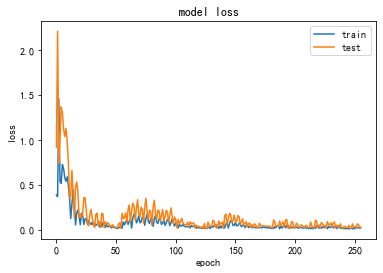

In [251]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [252]:
### Lets Do the prediction and check performance metrics
train_predict=model_keras_2.predict(X_train).reshape(-1,1)
test_predict=model_keras_2.predict(X_test).reshape(-1,1)
train_predict.shape, test_predict.shape

((65, 1), (31, 1))

In [253]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [254]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.10139446527354382
Train data MSE:  0.010280837588107883
Test data MAE:  0.08533142425827354
-------------------------------------------------------------------------------------
Test data RMSE:  0.122852090069082
Test data MSE:  0.015092636034341838
Test data MAE:  0.10997174283526127


In [255]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9898301564406943
Test data explained variance regression score: 0.8852813993172001
Train data R2 score: 0.9709867901521017
Test data R2 score: 0.6059827042132735


In [256]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

from itertools import cycle
names = cycle(['Original GDP','Train predicted GDP','Test predicted GDP'])


plotdf = pd.DataFrame({'date': df['Date'],
                       'original': df['GDP'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'GDP','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted GDP',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (118, 1)
Test predicted data:  (118, 1)


In [257]:
lstmdf=closedf.tolist()
#lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['GDP'])

fig = px.line(lstmdf,labels={'value': 'GDP','index': 'Timestamp'})
fig.update_layout(title_text='Plotting entire GDP with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Seasonal GDP')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

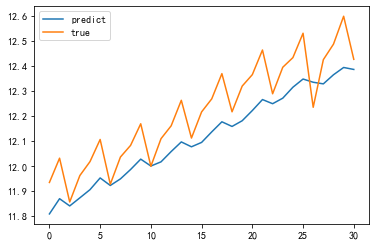

In [258]:
from matplotlib import pyplot
pyplot.plot(test_predict, label='predict')
pyplot.plot(original_ytest, label='true')
pyplot.legend()
pyplot.show()